In [1]:
import numpy as np
import pandas as pd
import sys
sys.path.append('./caml-mimic-master')
sys.path.append('./PLM-ICD-master/data/mimic3')
import datasets
import matplotlib

#### Preprocess ICD-to-phecode map file

In [6]:
icd_phecode_map = pd.read_csv("phecode_map/ICD_phecode_map.txt", sep=" ", dtype = str)
icd_phecode_map.sort_values(by = ['ICD', 'phecode_d1'], ascending = [True, False], inplace=True)
temp = icd_phecode_map.duplicated(subset=['ICD'])
icd_phecode_map = icd_phecode_map[~temp]
icd_phecode_map = icd_phecode_map[icd_phecode_map.CODE_TYPE == '09']

#### Match phecode to all_codes.csv

In [7]:
all_codes = pd.read_csv('PLM-ICD-master/data/mimic3/all_codes.csv')
all_codes_phe = all_codes.merge(icd_phecode_map, how='left', left_on='ICD9_CODE', right_on='ICD')
all_codes_phe.drop(['ICD_nodot', 'ICD', 'CODE_TYPE', 'coTypeCode', 'phecode'], axis=1, inplace= True)
all_codes_phe.phecode_d1.isna().sum()/len(all_codes_phe.index)
all_codes_phe.to_csv('PLM-ICD-master/data/mimic3/all_codes_w_phe.csv', index=False)

#### Match phecode to tain, dev, test files (full version)

In [2]:
train_ds_notes = pd.read_csv('PLM-ICD-master/data/mimic3/train_ds_notes_full.csv')
test_ds_notes = pd.read_csv('PLM-ICD-master/data/mimic3/test_ds_notes_full.csv')
dev_ds_notes = pd.read_csv('PLM-ICD-master/data/mimic3/dev_ds_notes_full.csv')

In [9]:
##create phecode list
def match_phe_codes(x):
    codes = x.split(';')
    phe_codes = icd_phecode_map.phecode_d1[icd_phecode_map.ICD.isin(codes)]
    return ';'.join(phe_codes) 

dffss = [train_ds_notes, dev_ds_notes, test_ds_notes]

for df in dffss:
    df['label'] = df['label'].astype(str)
    df['PHEd1_CODE'] = df['label'].apply(lambda x: match_phe_codes(x))
    df['n_PHEd1'] = df['PHEd1_CODE'].apply(lambda x: len(x.split(';')) if (len(x)>0) else 0)

In [ ]:
train_ds_notes = train_ds_notes[train_ds_notes['n_PHEd1']> 0]
test_ds_notes = test_ds_notes[test_ds_notes['n_PHEd1']> 0]
dev_ds_notes = dev_ds_notes[dev_ds_notes['n_PHEd1']> 0]

# rename and reorder columns
train_ds_notes.rename(columns={"TEXT": "sentence1", "PHEd1_CODE": "label" , "label": "ICD(_CODE)"}, inplace=True)
test_ds_notes.rename(columns={"TEXT": "sentence1", "PHEd1_CODE": "label", "label": "ICD(_CODE)"}, inplace=True)
dev_ds_notes.rename(columns={"TEXT": "sentence1", "PHEd1_CODE": "label", "label": "ICD(_CODE)"}, inplace=True)

train_ds_notes = train_ds_notes[['sentence1', 'label', 'SUBJECT_ID', 'HADM_ID', 'ICD9_CODE','length','n_PHEd1']]
test_ds_notes = test_ds_notes[['sentence1', 'label', 'SUBJECT_ID', 'HADM_ID', 'ICD9_CODE','length','n_PHEd1']]
dev_ds_notes = dev_ds_notes[['sentence1', 'label', 'SUBJECT_ID', 'HADM_ID', 'ICD9_CODE','length','n_PHEd1']]

train_ds_notes.to_csv('PLM-ICD-master/data/mimic3/train_ds_full_w_phe.csv', index = False)
test_ds_notes.to_csv('PLM-ICD-master/data/mimic3/test_ds_full_w_phe.csv', index = False)
dev_ds_notes.to_csv('PLM-ICD-master/data/mimic3/dev_ds_full_w_phe.csv', index = False)

In [11]:
###length of train, dev, test data
print("length of train data: ", len(train_ds_notes))
print("length of dev data: ", len(dev_ds_notes))
print("length of test data: ", len(test_ds_notes))

length of train data:  47714
length of dev data:  5963
length of test data:  5964


In [12]:
test_ds_notes.head()

,sentence1,label,SUBJECT_ID,HADM_ID,ICD9_CODE,length,n_PHEd1
0,"""admission date discharge date date of birth s...",250.2;276.5;285;250.6;401.1;411.4,17548,134871,414.01;276.5;250.60;357.2;401.9;285.9;36.13;36...,25,6
1,"""admission date discharge date date of birth s...",244.4;274.1;401.1;411.2;411.4;442.1;496;318,9588,100041,414.01;441.4;412;496;244.9;401.9;274.9;V15.82;...,31,8
2,"""admission date discharge date date of birth s...",038.2;401.2;415.2;428.1;496;509.1;081,4064,182461,518.81;403.91;996.62;038.10;428.0;496;416.8;E8...,34,7
3,"""admission date discharge date date of birth s...",285.1;401.2;428.1;447.1;600;854;411.4,15775,108010,996.74;428.0;403.91;285.1;E878.2;447.1;V45.81;...,34,7
4,"""admission date discharge date date of birth s...",041;285;290.2;317;401.1;411.2;501;586;695.4,17785,183076,410.01;303.91;291.0;507.0;285.9;401.9;593.9;04...,35,9


#### Save all phecodes

In [13]:
all_ds_notes = pd.concat([train_ds_notes, test_ds_notes, dev_ds_notes])
ALL_PHE_CODES = all_ds_notes.label
ALL_PHE_CODES = ALL_PHE_CODES[ALL_PHE_CODES != '']
ALL_PHE_CODES = ALL_PHE_CODES.apply(lambda x: x.split(';')).explode().unique()
len(ALL_PHE_CODES)

1411

In [65]:
pd.Series(ALL_PHE_CODES).to_csv('PLM-ICD-master/data/mimic3/ALL_PHE_CODES.txt', sep='\n', index=False, header=False)

<AxesSubplot:ylabel='Frequency'>

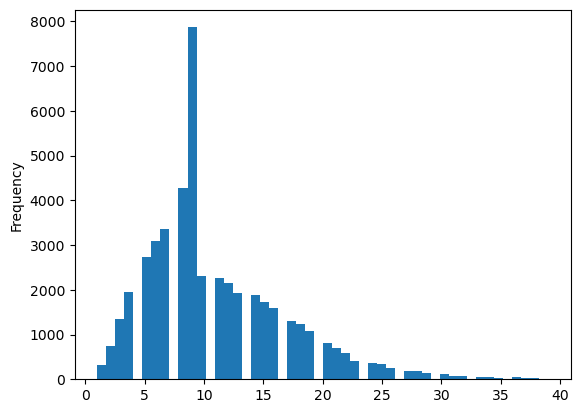

In [14]:
train_ds_notes.n_PHEd1.plot.hist(bins=50)